In [1]:
import os
import pandas as pd
import numpy as np
from scipy.spatial import ConvexHull, convex_hull_plot_2d


from cycler import cycler
import glob
import re

import pickle
import seaborn as sns


from utilities.utils import date_to_glab_output_file, OUTPUT_root, gLab_output_to_numpy
import itertools
import datetime

import plotly

from typing import Tuple,List
import mpld3
import pickle
import xarray


import matplotlib.pyplot as plt
from matplotlib.widgets import Button, Slider,RadioButtons

SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18


plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"

### Figure to HTML
https://stackoverflow.com/questions/65440054/how-to-save-an-interactive-plot-produced-by-matplot

In [2]:
dates_set_file_path = os.path.join('dates_set_single.pk')
stations_file_path = os.path.join('stations_single.pk')
agencies_file_path = os.path.join('agencies.pk')

if os.path.isfile(agencies_file_path):
    agencies = pickle.load(open(agencies_file_path,'rb')) + ['nic']

if os.path.isfile(stations_file_path):
    stations = pickle.load(open(stations_file_path,'rb'))

if os.path.isfile(dates_set_file_path):
    dates_sets = pickle.load(open(dates_set_file_path,'rb'))

# agencies_comb = []
# for comb in itertools.combinations(agencies, 2):
#     agencies_comb.append(comb)

years = list(set([d.year for s in dates_sets for d in s]))
dates_by_year = [[d for s in dates_sets for d in s if d.year == year ] for year in years ]

agencies,years,stations,dates_by_year

(['igs', 'ckm', 'nic'],
 [2024],
 ['ramo'],
 [[datetime.datetime(2024, 3, 19, 0, 0),
   datetime.datetime(2024, 3, 20, 0, 0),
   datetime.datetime(2024, 3, 21, 0, 0),
   datetime.datetime(2024, 3, 22, 0, 0),
   datetime.datetime(2024, 3, 23, 0, 0),
   datetime.datetime(2024, 3, 24, 0, 0),
   datetime.datetime(2024, 3, 25, 0, 0)]])

In [3]:
date = dates_sets[0][0]
station = stations[0]
agency = agencies[0]

out_filename = date_to_glab_output_file(date,station,agency)
out_filepath = os.path.join(OUTPUT_root,station,str(date.year),out_filename)
out_filepath,os.path.isfile(out_filepath),agencies

('OUT/ramo/2024/ramoigs0790.24out', True, ['igs', 'ckm', 'nic'])

In [4]:
def generate_xarray(glab_outputs_by_year : List[List[Tuple[str,str,str]]], agencies : List[str],station:str) -> xarray.DataArray:

    DAILY_SECONDS = 60*60*24
    FIVE_MINUTES_S = 60*5
    TIME_SPAN = DAILY_SECONDS//FIVE_MINUTES_S
    N_ERRORS = 3

    agency_index = {a:i for i,a in enumerate(agencies)}

    data = np.empty((len(agency_index),N_ERRORS,0,TIME_SPAN))
    data_dict = {a:np.empty((N_ERRORS,0,TIME_SPAN)) for a in agencies}
    dates = []
    times = np.linspace(FIVE_MINUTES_S,DAILY_SECONDS,TIME_SPAN)
    errors = np.array(['north','east','up'])

    for glab_outputs in glab_outputs_by_year:
        for output_file,agency,year,date in glab_outputs:
            
            neu,epochs = gLab_output_to_numpy(output_file)  
            
            indecies_to_fill = (epochs/FIVE_MINUTES_S).astype(int)
            nans = np.empty(shape=(TIME_SPAN,N_ERRORS))
            nans[:] = np.nan
            if len(indecies_to_fill) > 0: 
                nans[indecies_to_fill,:] = neu         

            neu = nans

            
            tmp_data = data_dict[agency]
            con_data = np.concatenate((tmp_data,np.expand_dims(neu.T,1)),1)
            data_dict[agency] = con_data


            idx = agency_index[agency]
            if idx == 0:dates.append(date)
            

            # print(data.shape,tmp_data.shape,con_data.shape,data_dict)

            # return
    dates = np.array(dates)
    for a in list(data_dict.values()):
        print(a.shape)
    data = np.stack(list(data_dict.values()))
    
    print(data.shape)
    print(('agency',list(agency_index.keys())),
                                      ('error',errors.shape),
                                      ('date',dates.shape),
                                      ('time(s)',times.shape))
    
    print(agency_index)

    data_array = xarray.DataArray(data,coords=
                                  [
                                      ('agency',list(agency_index.keys())),
                                      ('error',errors),
                                      ('date',dates),
                                      ('time(s)',times)
                                      ],name=station.upper())
    return data_array

In [5]:
NETCDF_FOLDER = 'netCDF'

In [6]:


for station in stations:
    # print(station)
    glab_outputs_by_year = [[(os.path.join(OUTPUT_root,station,str(date.year),
                              date_to_glab_output_file(date,station,agency)),
                              agency,str(date.year),date) for date in seq for agency in agencies] for seq in dates_sets ]
    
    data_array = generate_xarray(glab_outputs_by_year,agencies,station)

    cdf_file_path = os.path.join(NETCDF_FOLDER,'{}2022+.nc'.format(station.upper()))
    os.makedirs(os.path.dirname(cdf_file_path), exist_ok=True)
    if os.path.isfile(cdf_file_path): continue

    data_array.to_netcdf(cdf_file_path)

    # break



(3, 7, 288)
(3, 7, 288)
(3, 7, 288)
(3, 3, 7, 288)
('agency', ['igs', 'ckm', 'nic']) ('error', (3,)) ('date', (7,)) ('time(s)', (288,))
{'igs': 0, 'ckm': 1, 'nic': 2}


In [7]:
station = 'ramo'
cdf_file_path = os.path.join(NETCDF_FOLDER,'{}2022+.nc'.format(station.upper()))
data_array = xarray.open_dataarray(cdf_file_path)

In [26]:
a = data_array.loc['ckm','north'].mean().data
# plt.plot(a)
# plt.show()
a

array(1.4442572)

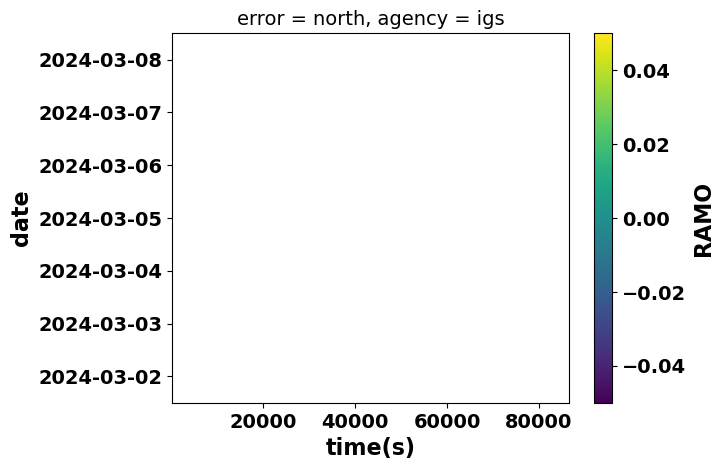

In [8]:
data_array[0,0].shift(date=-200).clip(-5,5).plot()
plt.show()

In [9]:
# (data_array[0,0,200:,:] - data_array[0,0,:-200,:]).plot()
(data_array[0,0,7,:] - data_array[0,0,0,:]+1).plot()
(data_array[0,0].shift(date=-700) - data_array[0,0]).clip(-5,5).dropna(dim='date',how='any').plot(cmap='inferno')

IndexError: index 7 is out of bounds for axis 0 with size 7

In [202]:
return
data_array.to_netcdf('t.nc')

data_array = xarray.open_dataarray('t.nc')


%matplotlib inline

data_array['date'].dt#.loc['north',:,:].plot(cmap='viridis')
masked = data_array.sel(date=data_array['date'].dt.year.isin([2012]))

a = masked.loc['igs','north']
# a.cla()
masked.name

'ALX2'

In [16]:
output_file = 'OUT/ramo/2022/ramoigs0010.22out'

# gLab_output_to_numpy(f)
with open(output_file,'r') as f:
    NEU_START,NEU_END = 17,20
    # list(map(float,l.split()[NEU_START:NEU_END]))
    lines = f.readlines()
    # print(lines)
    # neu=np.array([list(map(float,l.split()[NEU_START:NEU_END])) for l in lines if re.match('OUTPUT*', l)])

    for l in lines:
        print( re.match('OUTPUT*', l))

None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None


In [63]:
a = np.empty((3, 7, 285))
b = np.empty((3, 7, 285))

np.concatenate((a,b,b),axis=1).shape,np.stack((a,b)).shape,60*60*24//(60*5)

((3, 21, 285), (2, 3, 7, 285), 288)